In [28]:
import os

from platform import python_version
import warnings
import time
import datetime as dt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import multiprocessing as mp
import shutil

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.utils import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras import regularizers

import pandas as pd
import numpy as np
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

from PIL import Image
import xml.etree.ElementTree as ET
import psutil
import random

warnings.filterwarnings("ignore")
%matplotlib inline

In [29]:
# Example of preprocessing an image
def preprocess_image(image_path, target_size=(224, 224)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img_array

# Preprocess all images and labels
# This is a placeholder for the actual preprocessing loop

In [30]:
img_size = 96
epochs = 75
batch_size = 48
testsplit = .2
targetx = 96
targety = 96
learning_rate = 0.0001
classes = 7
seed = 23
print(seed)

data_dir = "KDEF/train"

23


In [31]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        brightness_range=[0.9,1.1],
        horizontal_flip=True,
        fill_mode='nearest',
    validation_split=testsplit
)


train_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=seed,
       subset="training"
)
val_generator = train_datagen.flow_from_directory(
        data_dir,
        target_size=(targetx, targety),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False,
        seed=seed,
     subset="validation",
        
)

Found 1881 images belonging to 7 classes.
Found 469 images belonging to 7 classes.


In [32]:
from tensorflow.keras.callbacks import *
checkpoint = ModelCheckpoint('RNKDEF.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             verbose=1,
                             mode='auto',
                             save_weights_only=False,
                             save_freq=1)

In [33]:
base_model = ResNet50V2(include_top=False, weights='imagenet', input_shape=(targetx, targety, 3))

# Custom Layers neccesarry to acheive high acurracy 
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten() (x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(512, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(256, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
x = Dense(128, activation='relu',  kernel_initializer=glorot_uniform(seed),kernel_regularizer=regularizers.L2(0.001),activity_regularizer=regularizers.L2(1e-4), bias_initializer='zeros')(x)
x = BatchNormalization()(x)
x=Dropout(0.3)(x)
predictions = Dense(classes, activation='softmax', kernel_initializer='random_uniform', bias_initializer='zeros')(x)

model = tf.keras.Model(inputs=base_model.input, outputs=predictions)
optimizer = Adam(learning_rate=learning_rate)
loss = "categorical_crossentropy"

for layer in model.layers:
    layer.trainable = True

model.compile(optimizer=optimizer,
              loss=loss,
              metrics=["accuracy"])


94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [34]:
# Check data generators
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")

# Check class indices
print(f"Training class indices: {train_generator.class_indices}")
print(f"Validation class indices: {val_generator.class_indices}")

# Check model summary
model.summary()

# Ensure correct optimizer and loss function
optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Ensure ModelCheckpoint is correctly configured used for callback to save the best value based on val_accuracy
checkpoint = ModelCheckpoint('RNKDEF.keras', monitor='val_accuracy', save_best_only=True, verbose=1)

# Train the model with callbacks
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=75,
    callbacks=[checkpoint]
)

Number of training samples: 40
Number of validation samples: 10
Training class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
Validation class indices: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)    │ (None, 96, 96, 3)         │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_pad (ZeroPadding2D)     │ (None, 102, 102, 3)       │               0 │ input_layer_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1_conv (Conv2D)           │ (None, 48, 48, 64)        │           9,472 │ conv1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pad (ZeroPadding2D)     │ (None, 50, 50, 64)        │               0 │ conv1_conv[0][0]           │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ pool1_pool (MaxPooling2D)     │ (None, 24, 24, 64)        │               0 │ pool1_pad[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_bn        │ (None, 24, 24, 64)        │             256 │ pool1_pool[0][0]           │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_preact_relu      │ (None, 24, 24, 64)        │               0 │ conv2_block1_preact_bn[0]… │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_conv (Conv2D)  │ (None, 24, 24, 64)        │           4,096 │ conv2_block1_preact_relu[… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_bn             │ (None, 24, 24, 64)        │             256 │ conv2_block1_1_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_1_relu           │ (None, 24, 24, 64)        │               0 │ conv2_block1_1_bn[0][0]    │
│ (Activation)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_pad            │ (None, 26, 26, 64)        │               0 │ conv2_block1_1_relu[0][0]  │
│ (ZeroPadding2D)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_conv (Conv2D)  │ (None, 24, 24, 64)        │          36,864 │ conv2_block1_2_pad[0][0]   │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_bn             │ (None, 24, 24, 64)        │             256 │ conv2_block1_2_conv[0][0]  │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_block1_2_relu           │ (None, 24, 24, 64)        │               0 │ conv2_block1_2_bn[0][0]    │
│ (Activation)                  │                           │               

 Total params: 24,790,791 (94.57 MB)

 Trainable params: 24,739,463 (94.37 MB)

 Non-trainable params: 51,328 (200.50 KB)

Epoch 1/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 663ms/step - accuracy: 0.1434 - loss: 7.0912
Epoch 1: val_accuracy improved from -inf to 0.15352, saving model to RNKDEF.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 60s 803ms/step - accuracy: 0.1438 - loss: 7.0911 - val_accuracy: 0.1535 - val_loss: 7.1379
Epoch 2/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.1638 - loss: 6.5773
Epoch 2: val_accuracy improved from 0.15352 to 0.18337, saving model to RNKDEF.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 31s 738ms/step - accuracy: 0.1641 - loss: 6.5686 - val_accuracy: 0.1834 - val_loss: 4.2759
Epoch 3/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 623ms/step - accuracy: 0.1641 - loss: 5.3237
Epoch 3: val_accuracy improved from 0.18337 to 0.18977, saving model to RNKDEF.keras
40/40 ━━━━━━━━━━━━━━━━━━━━ 30s 721ms/step - accuracy: 0.1642 - loss: 5.3214 - val_accuracy: 0.1898 - val_loss: 3.6681
Epoch 4/75
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.1784 - loss: 5.0907
Epoch 4: val_accuracy did not improve from 0.18977

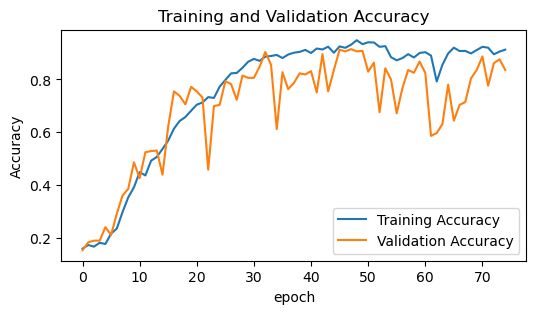

In [35]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

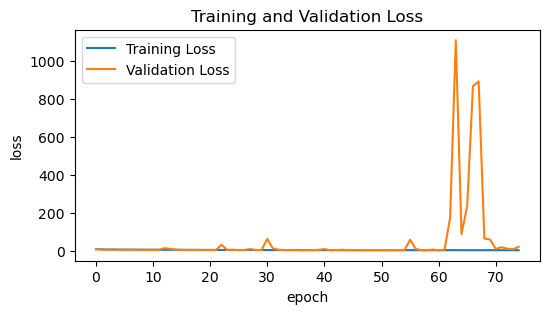

In [36]:
f, ax=plt.subplots(figsize=(6,3))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [37]:
import tensorflow as tf
model =tf.keras.models.load_model('RNKDEF.keras')
predictions = model.predict(val_generator, steps=len(val_generator))
y = np.argmax(predictions, axis=1)

print('Classification Report')
cr = classification_report(y_true=val_generator.classes, y_pred=y, target_names=val_generator.class_indices)
print(cr)

10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 474ms/step
Classification Report
              precision    recall  f1-score   support

       angry       0.95      0.91      0.93        67
     disgust       0.98      0.79      0.88        67
        fear       0.83      0.88      0.86        67
       happy       0.97      0.99      0.98        67
     neutral       0.97      0.97      0.97        67
         sad       0.83      0.93      0.87        67
    surprise       0.90      0.94      0.92        67

    accuracy                           0.91       469
   macro avg       0.92      0.91      0.91       469
weighted avg       0.92      0.91      0.91       469



10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 261ms/step


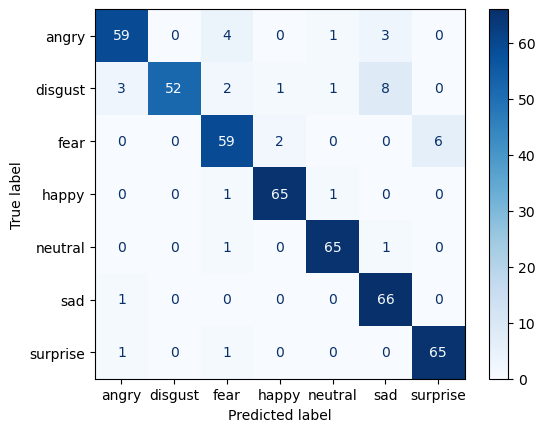

In [38]:
Y_pred = model.predict(val_generator)
y_pred = np.argmax(Y_pred, axis=1)
y_true=val_generator.classes

from sklearn.metrics import confusion_matrix
cm=confusion_matrix(y_true,y_pred)
cm

labels=['angry','disgust','fear','happy','neutral','sad','surprise']
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)

disp.plot(cmap=plt.cm.Blues)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
Predicted Emotion: happy


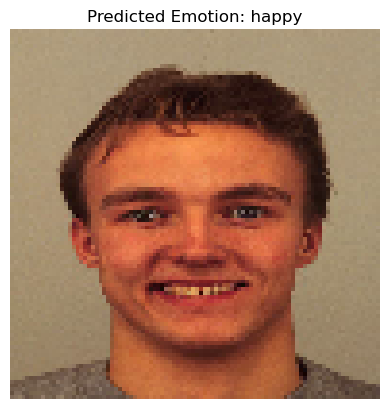

In [40]:
# Ensure you have matplotlib installed, otherwise install it using pip
# pip install matplotlib

import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg19 import preprocess_input

def preprocess_image(image_path, target_size=(96,96)):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)
    return img, img_array  # Return both the PIL image and the preprocessed array
# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('32_21.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted Emotion: happy


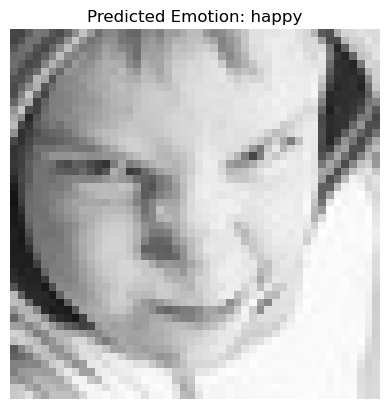

In [41]:

# Now you can use the preprocess_image function
original_img, img_array = preprocess_image('PrivateTest_20588149.jpg')
prediction = model.predict(img_array)

# Get the index of the highest probability in the prediction
predicted_index = np.argmax(prediction)

# Assuming you have a list of class labels
class_labels = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']  # Example labels

# Map the predicted index to the corresponding label
predicted_label = class_labels[predicted_index]

# Print the predicted label as a string
print(f"Predicted Emotion: {predicted_label}")

# Display the image using matplotlib
plt.imshow(original_img)
plt.title(f"Predicted Emotion: {predicted_label}")
plt.axis('off')  # Turn off the axis
plt.show()  # Display the plot